In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle_api/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!kaggle datasets download -d prathumarikeri/indian-sign-language-isl

Dataset URL: https://www.kaggle.com/datasets/prathumarikeri/indian-sign-language-isl
License(s): CC-BY-SA-4.0
 99% 278M/281M [00:18<00:00, 17.7MB/s]
100% 281M/281M [00:18<00:00, 15.5MB/s]


In [ ]:
!unzip /content/indian-sign-language-isl.zip

Streaming output truncated to the last 5000 lines.
  inflating: Indian/V/819.jpg        
  inflating: Indian/V/82.jpg         
  inflating: Indian/V/820.jpg        
  inflating: Indian/V/821.jpg        
  inflating: Indian/V/822.jpg        
  inflating: Indian/V/823.jpg        
  inflating: Indian/V/824.jpg        
  inflating: Indian/V/825.jpg        
  inflating: Indian/V/826.jpg        
  inflating: Indian/V/827.jpg        
  inflating: Indian/V/828.jpg        
  inflating: Indian/V/829.jpg        
  inflating: Indian/V/83.jpg         
  inflating: Indian/V/830.jpg        
  inflating: Indian/V/831.jpg        
  inflating: Indian/V/832.jpg        
  inflating: Indian/V/833.jpg        
  inflating: Indian/V/834.jpg        
  inflating: Indian/V/835.jpg        
  inflating: Indian/V/836.jpg        
  inflating: Indian/V/837.jpg        
  inflating: Indian/V/838.jpg        
  inflating: Indian/V/839.jpg        
  inflating: Indian/V/84.jpg         
  inflating: Indian/V/840.jpg        

In [ ]:
root_dir = "/content/Indian"

# Maximum number of images to load from each subdir_path
max_images_per_subdir = 500

# Initialize a list to store the image data
image_data = []

# Iterate through the subdirectories in the root directory
for label in os.listdir(root_dir):
    # check if the subdirectory is numeric
    if not label.isdigit():
        # Get the path to the subdirectory
        subdir_path = os.path.join(root_dir, label)

        # Use list comprehension to load a maximum images
        images = [
            {'label': label, 'color_image': Image.open(os.path.join(subdir_path, file))}
            for i, file in enumerate(os.listdir(subdir_path))
            if i < max_images_per_subdir
        ]

        # Extend the image_data list with the loaded images
        image_data.extend(images)

        # Check if the maximum number of images has been reached
        if len(images) == max_images_per_subdir:
            continue

# Create a DataFrame from the image data
df = pd.DataFrame(image_data)

In [ ]:
df


,label,color_image
0,D,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,D,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,D,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,D,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,D,<PIL.JpegImagePlugin.JpegImageFile image mode=...
...,...,...
12995,V,<PIL.JpegImagePlugin.JpegImageFile image mode=...
12996,V,<PIL.JpegImagePlugin.JpegImageFile image mode=...
12997,V,<PIL.JpegImagePlugin.JpegImageFile image mode=...
12998,V,<PIL.JpegImagePlugin.JpegImageFile image mode=...


In [ ]:
import matplotlib.pyplot as plt

# Get the first image from the list
image = images[0]


# Show the image using matplotlib
print(image)



{'label': 'C', 'color_image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=128x128 at 0x7CDEF5C7F8B0>}


In [ ]:
df['label'].unique()

array(['O', 'B', 'P', 'T', 'Y', 'I', 'W', 'M', 'K', 'N', 'Z', 'D', 'L',
       'Q', 'H', 'R', 'F', 'A', 'E', 'S', 'V', 'U', 'X', 'J', 'G', 'C'],
      dtype=object)

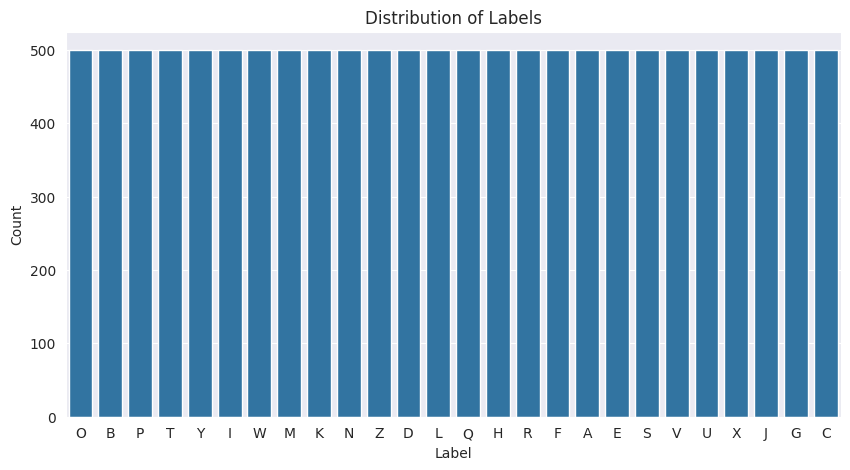

In [ ]:
plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")
sns.countplot(data=df,x='label')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')

plt.show()

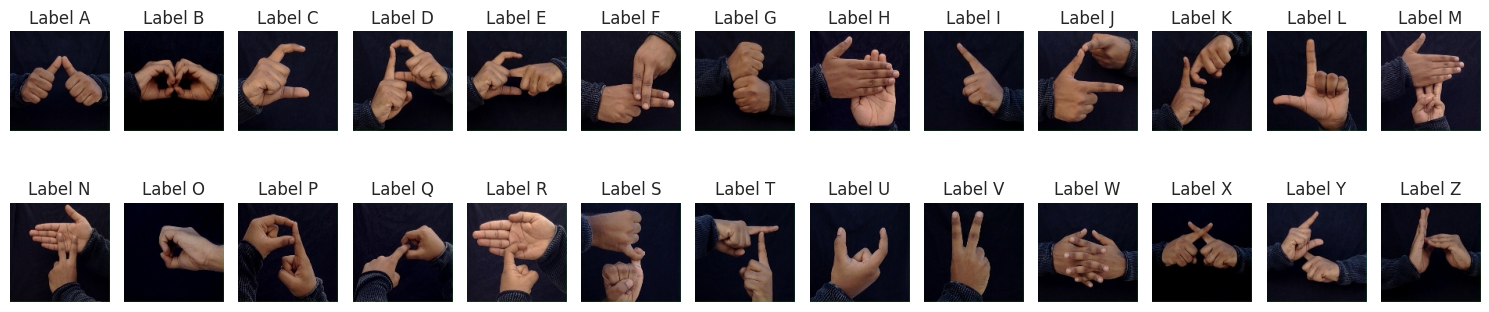

In [ ]:
fig, axs = plt.subplots(2,13, figsize=(15, 4))

for i, (label, image) in enumerate(df.groupby('label').first().reset_index()[['label', 'color_image']].itertuples(index=False)):
    ax = axs[i // 13, i % 13]
    ax.imshow(image)
    ax.set_title('Label {}'.format(label))
    ax.axis('off')

plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
images = np.array(df['color_image'])
labels = np.array(df['label'])

In [ ]:
labels.shape

(13000,)

In [ ]:
print(labels[0])

E


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=128x128 at 0x7ED3F168F610>


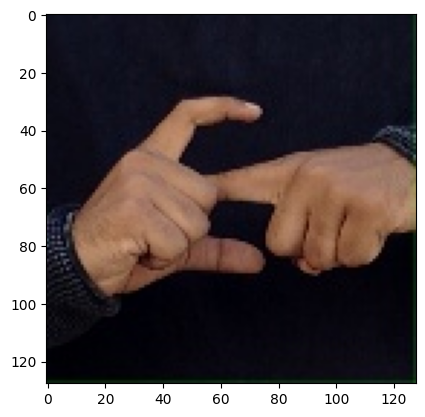

In [ ]:
print(images[0])
plt.imshow(images[0])

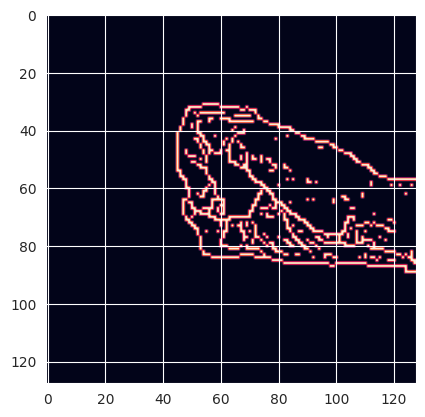

In [ ]:
import cv2
resized_images = []
def get_canny_edge(image):
    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    HSVImaage = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lowerBoundary = np.array([0,40,30],dtype="uint8")
    upperBoundary = np.array([43,255,254],dtype="uint8")
    skinMask = cv2.inRange(HSVImaage, lowerBoundary, upperBoundary)
    skin = cv2.bitwise_and(grayImage, grayImage, mask = skinMask)
    canny = cv2.Canny(skin,60,60)
    return canny
for image in images:
    resized_image = image.resize((128, 128))  # Resize the image to the desired size
    image=np.array(resized_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image=get_canny_edge(image)
    resized_image = np.expand_dims( resized_image, axis=-1)
    resized_images.append(resized_image)
images = np.array(resized_images)
plt.imshow(images[0])

In [ ]:
print(images[0].shape)

(128, 128, 1)


In [ ]:
# Normalize pixel values
images = images / 255.0
images[0].shape
print(images[0])

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


In [ ]:
# Map labels to numerical values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
print(labels)

[4 4 4 ... 0 0 0]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
print(labels)

[4 4 4 ... 0 0 0]


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
# Convert labels to categorical format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

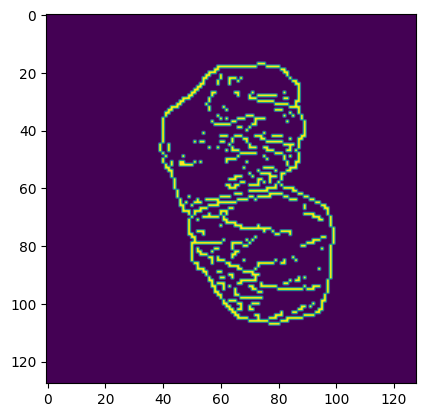

In [ ]:
plt.figure()
plt.imshow(images[0])
plt.show()

In [ ]:
X_train.shape

(10400,)

In [ ]:
model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding='same', activation='relu', input_shape=(128, 128, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(50, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(25, (3, 3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=26, activation='softmax'))

model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 75)      750       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 75)      300       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 75)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 64, 64, 50)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 50)        2

In [ ]:
!mkdir /kaggle/working
!chmod 777 /kaggle/working

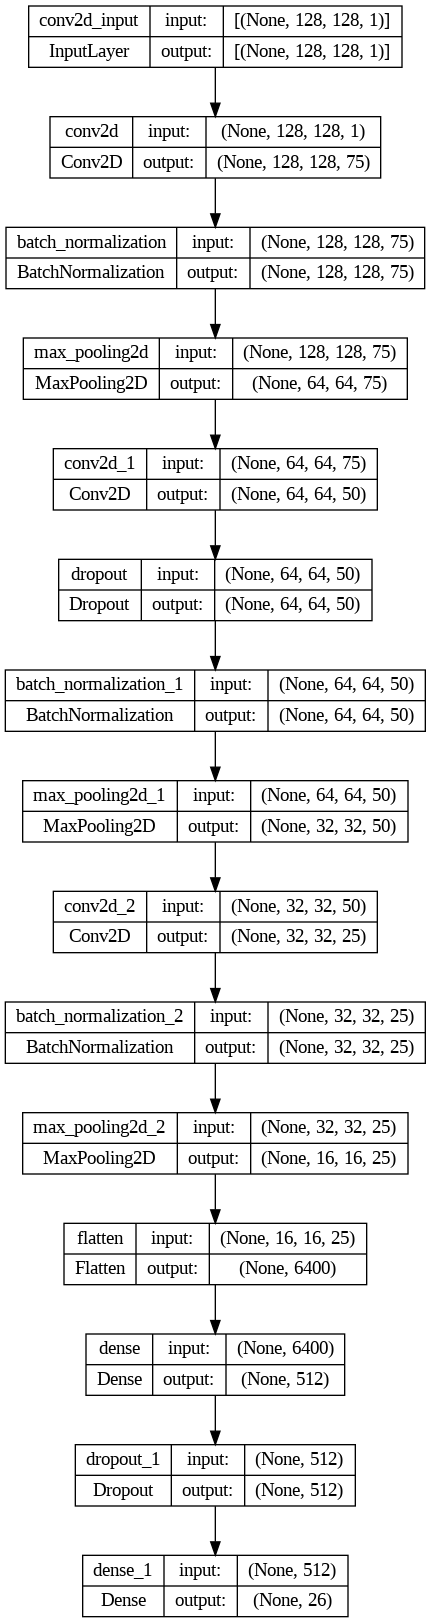

In [ ]:
plot_model(model, to_file='/kaggle/working/model_architecture2.png', show_shapes=True, show_layer_names=True)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images



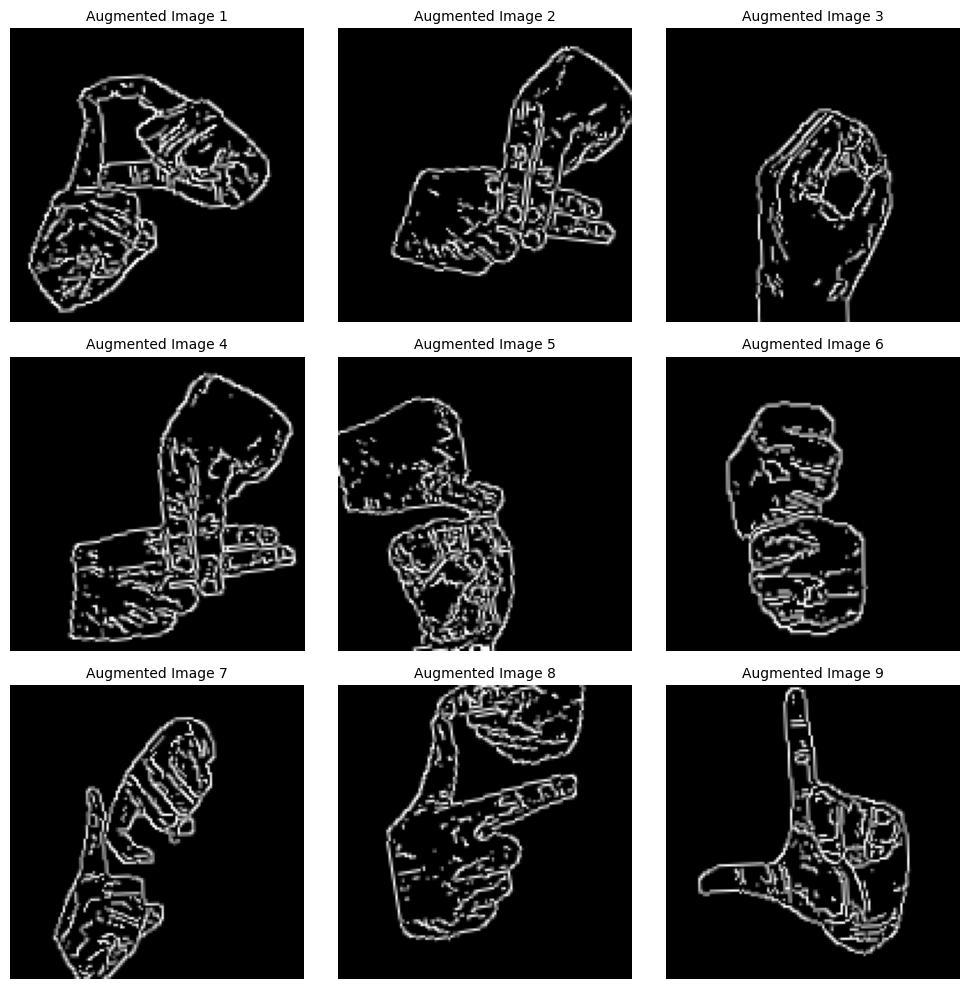

In [ ]:
datagen.fit(X_train)


augmented_images = []
for X_batch, _ in datagen.flow(X_train, y_train, batch_size=9):  # Use underscore to ignore the labels
    for img in X_batch:
        augmented_images.append(img)
    break  # Generate only one batch of augmented images

# Display augmented images
plt.figure(figsize=(10, 10))
for i, image in enumerate(augmented_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')  # Squeeze to remove the channel dimension
    plt.title(f'Augmented Image {i + 1}', fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.001)
history = model.fit(datagen.flow(X_train,y_train), epochs=10, validation_data=(X_test, y_test), callbacks=[learning_rate_reduction])

Epoch 1/10
325/325 [==============================] - ETA: 0s - loss: 0.4894 - accuracy: 0.8715

325/325 [==============================] - 32s 72ms/step - loss: 0.4894 - accuracy: 0.8715 - val_loss: 2.6267 - val_accuracy: 0.1696 - lr: 0.0100
Epoch 2/10
325/325 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9815

325/325 [==============================] - 24s 74ms/step - loss: 0.0727 - accuracy: 0.9815 - val_loss: 0.0087 - val_accuracy: 0.9996 - lr: 0.0100
Epoch 3/10
325/325 [==============================] - ETA: 0s - loss: 0.0356 - accuracy: 0.9916

325/325 [==============================] - 23s 71ms/step - loss: 0.0356 - accuracy: 0.9916 - val_loss: 9.6445e-04 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 4/10
325/325 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9937

325/325 [==============================] - 24s 72ms/step - loss: 0.0271 - accuracy: 0.9937 - val_loss: 5.2775e-04 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 5/10
325/325 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9948

325/325 [==============================] - 22s 68ms/step - loss: 0.0207 - accuracy: 0.9948 - val_loss: 3.1386e-04 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 6/10
325/325 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9968

325/325 [==============================] - 24s 72ms/step - loss: 0.0144 - accuracy: 0.9968 - val_loss: 3.1241e-04 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 7/10
325/325 [==============================] - ETA: 0s - loss: 0.0132 - accuracy: 0.9976

325/325 [==============================] - 23s 70ms/step - loss: 0.0132 - accuracy: 0.9976 - val_loss: 1.9380e-04 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 8/10
325/325 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9983

325/325 [==============================] - 23s 71ms/step - loss: 0.0094 - accuracy: 0.9983 - val_loss: 2.0522e-04 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 9/10
325/325 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 0.9981

325/325 [==============================] - 23s 70ms/step - loss: 0.0099 - accuracy: 0.9981 - val_loss: 1.4448e-04 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 10/10
325/325 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9978

325/325 [==============================] - 24s 73ms/step - loss: 0.0090 - accuracy: 0.9978 - val_loss: 1.8295e-04 - val_accuracy: 1.0000 - lr: 0.0100


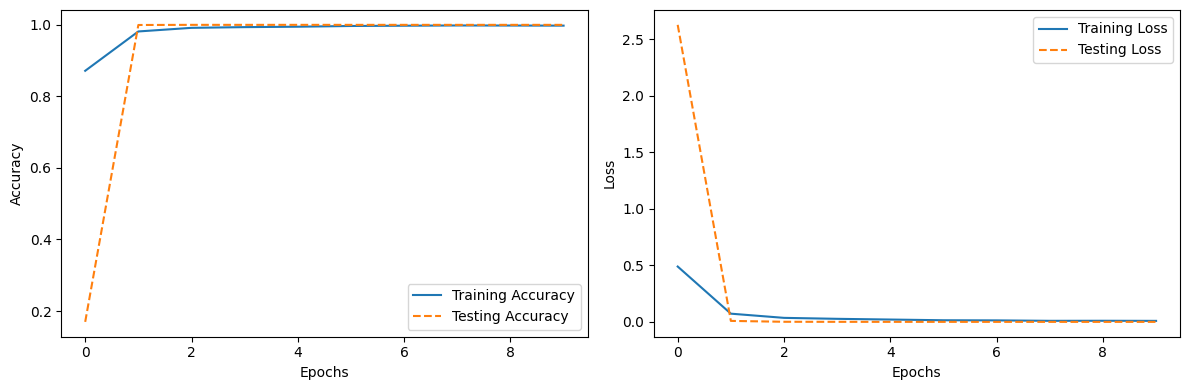

In [ ]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Define plot labels and styles
plot_labels = ['Accuracy', 'Loss']
plot_styles = ['-', '--']

# Plot training and testing accuracy/loss
for i, metric in enumerate(['accuracy', 'loss']):
    train_metric = history.history[metric]
    test_metric = history.history['val_' + metric]
    axs[i].plot(train_metric, label='Training ' + metric.capitalize(), linestyle=plot_styles[0])
    axs[i].plot(test_metric, label='Testing ' + metric.capitalize(), linestyle=plot_styles[1])
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel(plot_labels[i])
    axs[i].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Get the model's predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

82/82 [==============================] - 1s 8ms/step


In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

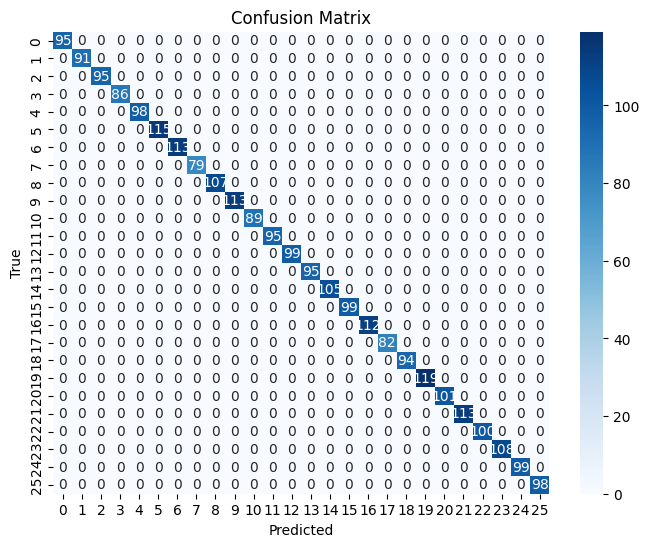

In [ ]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

accuracy = model.evaluate(X_test, y_test)
print(f'validation test results - Loss: {accuracy[0]} - Accuracy: {accuracy[1]*100}%')

82/82 [==============================] - 1s 9ms/step - loss: 1.8295e-04 - accuracy: 1.0000
validation test results - Loss: 0.00018295257177669555 - Accuracy: 100.0%


In [ ]:
model.save("indianSignLanguage.h5")


1/1 [==============================] - 0s 435ms/step


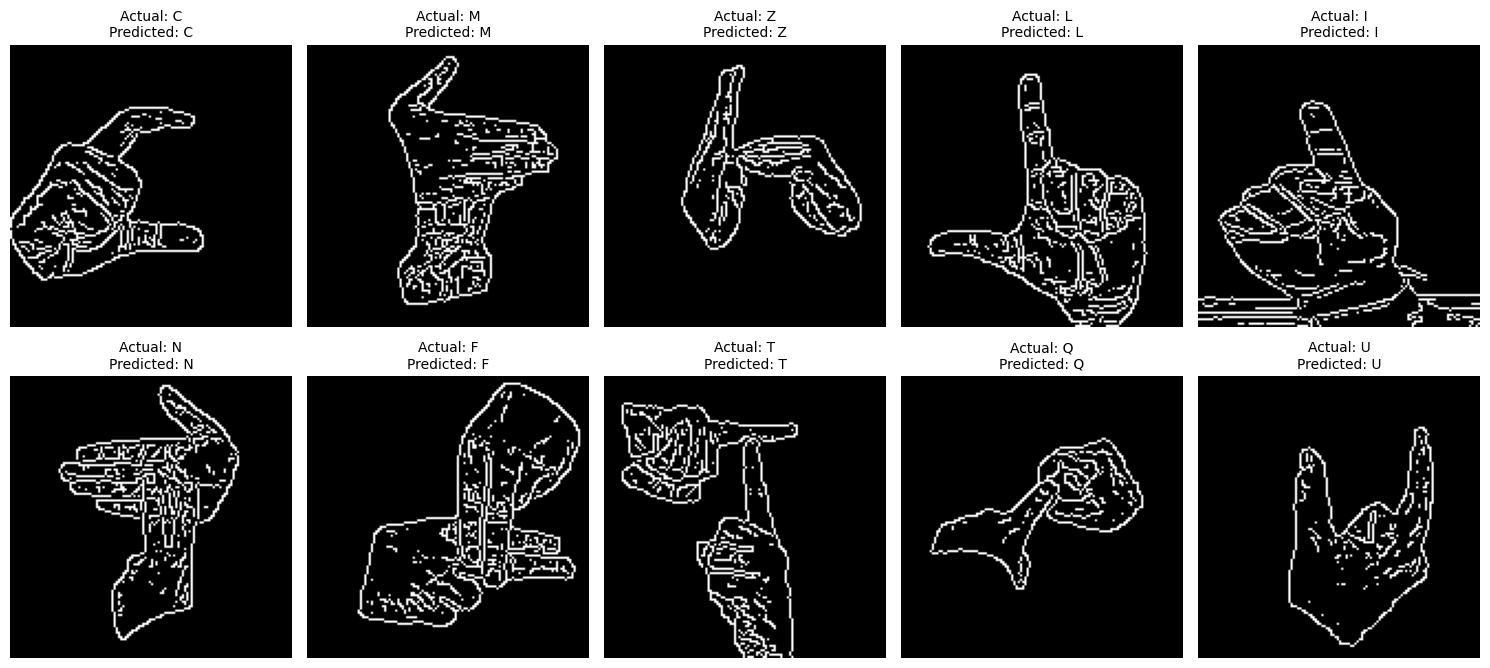

In [ ]:
# Get model predictions for the first 10 images in the test set

predictions = model.predict(X_test[:10])
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(y_test[:10], axis=1)

# Decode labels using label encoder
predicted_labels = label_encoder.inverse_transform(predicted_labels)
actual_labels = label_encoder.inverse_transform(actual_labels)

# Display actual and predicted labels along with images for the first 10 images
plt.figure(figsize=(15, 7))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i], cmap='gray')
    plt.title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_labels[i]}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import joblib
joblib.dump(model,"hand_sign.joblib")

['hand_sign.joblib']

In [ ]:

from PIL import Image
import matplotlib.image as im
img = Image.open('/content/drive/MyDrive/abs (20)')

import cv2

# Convert BGR to RGB
img=np.array(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

def get_canny_edge(image):
    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    HSVImaage = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lowerBoundary = np.array([0,40,30],dtype="uint8")
    upperBoundary = np.array([43,255,254],dtype="uint8")
    skinMask = cv2.inRange(HSVImaage, lowerBoundary, upperBoundary)

    skin = cv2.bitwise_and(grayImage, grayImage, mask = skinMask)
    canny = cv2.Canny(skin,60,60)
    return skin

img=get_canny_edge(img)

(500, 500)


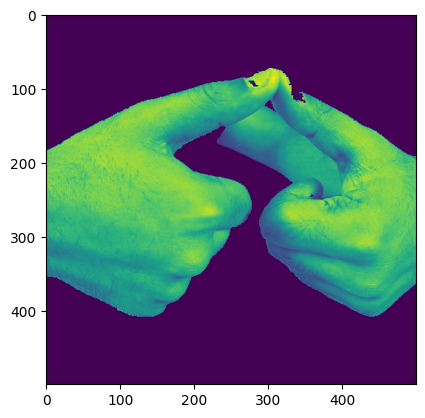

In [ ]:
plt.imshow(img)
print(img.shape)

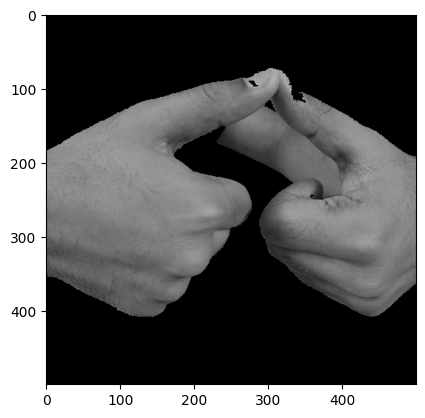

In [ ]:
plt.imshow(img)

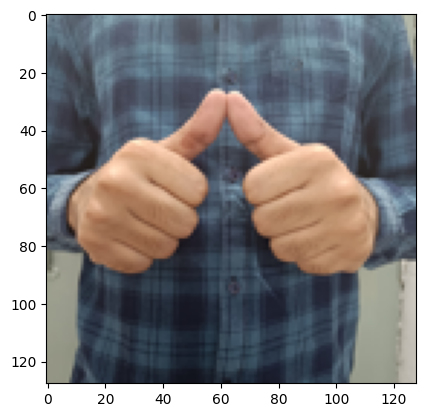

In [ ]:
img = Image.open('/content/drive/MyDrive/signs/A/abs(27).jpg')

import cv2

# Convert BGR to RGB
img=img.resize((128,128))
plt.imshow(img)



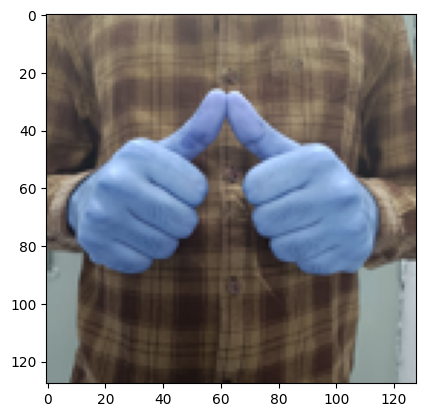

In [ ]:
img=np.array(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)



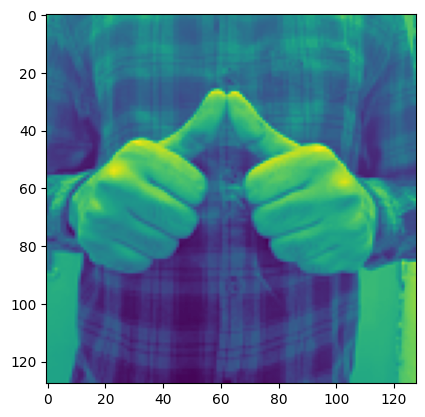

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

def get_canny_edge(image):
    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    HSVImaage = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lowerBoundary = np.array([0,40,30],dtype="uint8")
    upperBoundary = np.array([43,255,254],dtype="uint8")
    skinMask = cv2.inRange(HSVImaage, lowerBoundary, upperBoundary)

    skin = cv2.bitwise_and(grayImage, grayImage, mask = skinMask)

    canny = cv2.Canny(skin,60,60)
    return grayImage
img = get_canny_edge(img)
plt.imshow(img)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(128, 128, 1)
(1, 128, 128, 1)
(128, 128, 1)
1/1 [==============================] - 1s 1s/step
A


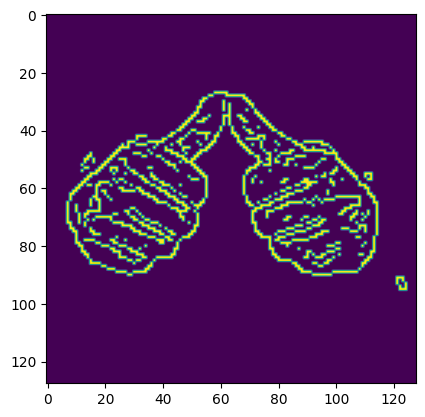

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.image as im
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode


img = Image.open('/content/drive/MyDrive/signs/A/abs(27).jpg')

import cv2

# Convert BGR to RGB
img=img.resize((128,128))
img=np.array(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

def get_canny_edge(image):
    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    HSVImaage = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lowerBoundary = np.array([0,40,30],dtype="uint8")
    upperBoundary = np.array([43,255,254],dtype="uint8")
    skinMask = cv2.inRange(HSVImaage, lowerBoundary, upperBoundary)

    skin = cv2.bitwise_and(grayImage, grayImage, mask = skinMask)
    canny = cv2.Canny(skin,60,60)
    return canny
img = get_canny_edge(img)
img = np.expand_dims(img, axis=-1)
#img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

from PIL import Image



img=img/255.0

plt.imshow(img)
print(img.shape)



import joblib

mode = tf.keras.models.load_model('/content/drive/MyDrive/indianSignLanguage (2).h5')
m=[]
import pickle
with open('/content/drive/MyDrive/labels.pkl', 'rb') as f:
  labels = pickle.load(f)

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


m.append(img)
m=np.array(m)
print(m.shape)
#datagen.fit(m)
#m = datagen.flow(m, batch_size=1)
print(m[0].shape)
probabilities = mode.predict(m)

# Get the predicted label
predicted_label = np.argmax(probabilities)
p=[]
p.append(predicted_label)
predicted_labels = label_encoder.inverse_transform(p)
print(predicted_labels[0])

In [ ]:

root_dir = "/content/drive/MyDrive/signs"

# Maximum number of images to load from each subdir_path
max_images_per_subdir = 1

# Initialize a list to store the image data
image_data = []

# Iterate through the subdirectories in the root directory
for label in os.listdir(root_dir):
    # check if the subdirectory is numeric
    if not label.isdigit():
        # Get the path to the subdirectory
        subdir_path = os.path.join(root_dir, label)

        # Use list comprehension to load a maximum images
        images = [
            {'label': label, 'color_image': Image.open(os.path.join(subdir_path, file))}
            for i, file in enumerate(os.listdir(subdir_path))
            if i < max_images_per_subdir
        ]

        # Extend the image_data list with the loaded images
        image_data.extend(images)

        # Check if the maximum number of images has been reached
        if len(images) == max_images_per_subdir:
            continue

# Create a DataFrame from the image data
df = pd.DataFrame(image_data)
images = np.array(df['color_image'])
labels = np.array(df['label'])

In [ ]:
images=images/255.0
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

1/1 [==============================] - 1s 603ms/step
Accuracy: 0.8333333333333334


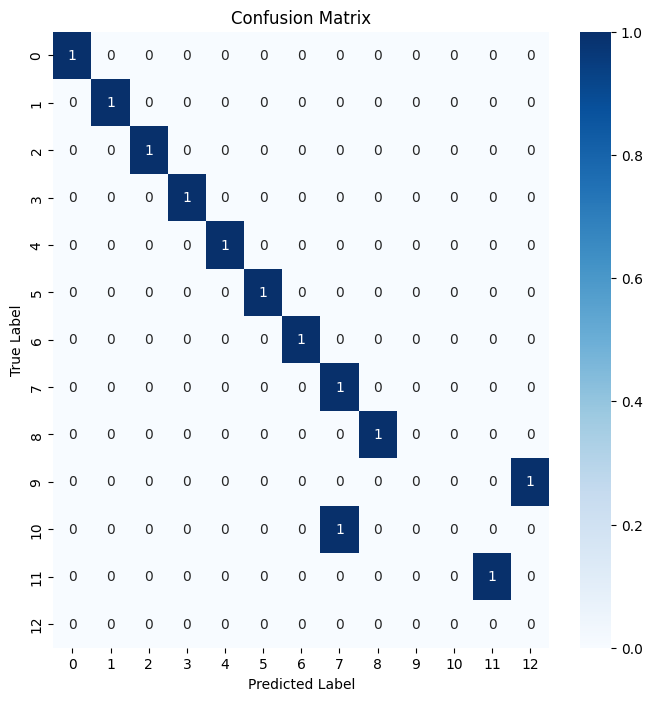

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       0.50      1.00      0.67         1
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       1.00      1.00      1.00         1
          16       0.00      0.00      0.00         0

    accuracy                           0.83        12
   macro avg       0.73      0.77      0.74        12
weighted avg       0.79      0.83      0.81        12



In [ ]:


# Import necessary libraries
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Import the confusion_matrix function
from sklearn.metrics import precision_recall_curve, roc_curve # Import the precision_recall_curve and roc_curve functions

# Make predictions on the test images
predictions = mode.predict(images)

# Convert the predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the accuracy
accuracy = accuracy_score(labels, predicted_labels)

# Print the accuracy
print("Accuracy:", accuracy)
# Create a confusion matrix
confusion_matrix = confusion_matrix(labels, predicted_labels) # Use the confusion_matrix function from sklearn.metrics

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print a classification report
print(classification_report(labels, predicted_labels))



In [ ]:
import joblib
mode = joblib.load('/content/drive/MyDrive/model.joblib')

In [ ]:
root_dir = "/content/drive/MyDrive/signs"

# Maximum number of images to load from each subdir_path
max_images_per_subdir = 1

# Initialize a list to store the image data
image_data = []

# Iterate through the subdirectories in the root directory
for label in os.listdir(root_dir):
    # check if the subdirectory is numeric
    if not label.isdigit():
        # Get the path to the subdirectory
        subdir_path = os.path.join(root_dir, label)

        # Use list comprehension to load a maximum images
        images = [
            {'label': label, 'color_image': Image.open(os.path.join(subdir_path, file))}
            for i, file in enumerate(os.listdir(subdir_path))
            if i < max_images_per_subdir
        ]

        # Extend the image_data list with the loaded images
        image_data.extend(images)

        # Check if the maximum number of images has been reached
        if len(images) == max_images_per_subdir:
            continue

# Create a DataFrame from the image data
df = pd.DataFrame(image_data)
images = np.array(df['color_image'])
labels = np.array(df['label'])

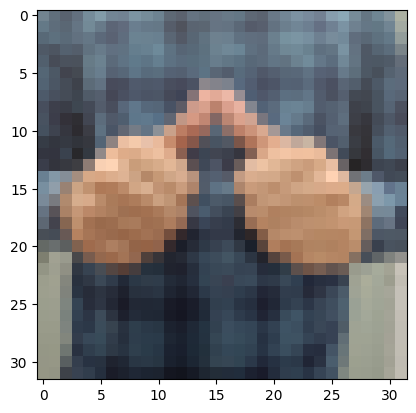

In [ ]:
resized_images = []
for image in images:
    resized_image = image.resize((32, 32))  # Resize the image to the desired size
    resized_images.append(np.array(resized_image))
images = np.array(resized_images)
plt.imshow(images[0])

In [ ]:
images=images/255.0
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

1/1 [==============================] - 0s 57ms/step
Accuracy: 0.08333333333333333


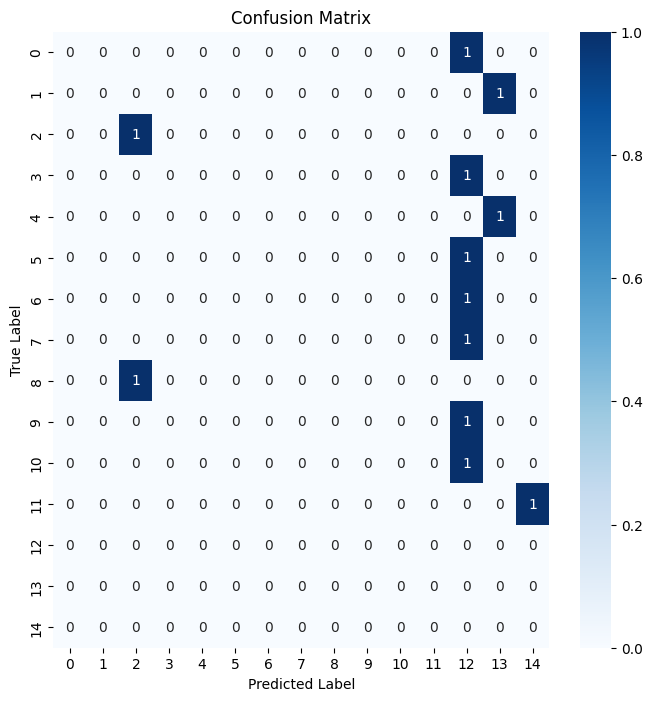

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0

    accuracy                           0.08        12
   macro avg       0.03      0.07      0.04        12
weighted avg       0.04   

In [ ]:


# Import necessary libraries
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Import the confusion_matrix function
from sklearn.metrics import precision_recall_curve, roc_curve # Import the precision_recall_curve and roc_curve functions

# Make predictions on the test images
predictions = mode.predict(images)

# Convert the predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the accuracy
accuracy = accuracy_score(labels, predicted_labels)

# Print the accuracy
print("Accuracy:", accuracy)
# Create a confusion matrix
confusion_matrix = confusion_matrix(labels, predicted_labels) # Use the confusion_matrix function from sklearn.metrics

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print a classification report
print(classification_report(labels, predicted_labels))



In [ ]:
import tensorflow as tf

# Load the .h5 model
h5_model_path = '/content/drive/MyDrive/indianSignLanguage (2).h5'
model = tf.keras.models.load_model(h5_model_path)

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a .tflite file
tflite_model_path = 'prediction.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

In [ ]:

import joblib
mod=joblib.load('/content/drive/MyDrive/latest.joblib')
m=[]
import pickle
#with open('/content/drive/MyDrive/labels.pkl', 'rb') as f:
 #   labels = pickle.load(f)

#label_encoder = LabelEncoder()
#labels = label_encoder.fit_transform(labels)
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


m.append(img)
m=np.array(m)
print(m.shape)
datagen.fit(m)
m = datagen.flow(m, batch_size=1)
print(m[0].shape)
predicted_labels=([np.argmax(mod.predict(m))])
predicted_labels = label_encoder.inverse_transform(predicted_labels)
print(predicted_labels)

(1, 128, 128, 1)
(1, 128, 128, 1)
1/1 [==============================] - 0s 305ms/step
[21]
